In [25]:
import os
os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import seaborn as sns
import random

def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds(42)

In [26]:
site_1 = pd.read_pickle("utilization_data_site1.pkl")
site_2 = pd.read_pickle("utilization_data_site2.pkl")

In [27]:
site_1

,hour,weekday,month,holiday,utilization,temperature,precipitation
0,13,0,10,True,0.076923,13.0,0.0
1,14,0,10,True,0.365385,14.0,0.0
2,15,0,10,True,0.365385,17.0,0.0
3,16,0,10,True,0.365385,18.0,0.0
4,17,0,10,True,0.365385,20.0,0.0
...,...,...,...,...,...,...,...
12966,19,1,3,True,0.057692,23.0,0.0
12967,20,1,3,True,0.057692,24.0,0.0
12968,21,1,3,True,0.057692,25.0,0.0
12969,22,1,3,True,0.057692,24.0,0.0


In [28]:
site_1_X = site_1.drop(columns = "utilization")
site_1_y = site_1['utilization']
site_2_X = site_2.drop(columns = 'utilization')
site_2_y = site_2['utilization']

In [29]:
# Split data into train, test, validation 60/20/20
site_1_X_train, site_1_X_test, site_1_y_train, site_1_y_test = train_test_split(site_1_X, site_1_y, test_size= 0.4, random_state=42)
site_2_X_train, site_2_X_test, site_2_y_train, site_2_y_test = train_test_split(site_2_X, site_2_y, test_size= 0.4, random_state=42)

site_1_X_test, site_1_X_val, site_1_y_test, site_1_y_val = train_test_split(site_1_X_test, site_1_y_test, test_size=0.5, random_state=42)
site_2_X_test, site_2_X_val, site_2_y_test, site_2_y_val = train_test_split(site_2_X_test, site_2_y_test, test_size=0.5, random_state=42)

In [30]:
# Scale data using MinMaxScaler from sklearn
site_1_scaler = MinMaxScaler()
site_2_scaler = MinMaxScaler()

site_1_scaler.fit(site_1_X_train)
site_2_scaler.fit(site_2_X_train)

site_1_X_train = site_1_scaler.fit_transform(site_1_X_train)
site_1_X_test  = site_1_scaler.transform(site_1_X_test)
site_1_X_val  = site_1_scaler.transform(site_1_X_val)


site_2_X_train = site_2_scaler.fit_transform(site_2_X_train)
site_2_X_test  = site_2_scaler.transform(site_2_X_test)
site_2_X_val  = site_2_scaler.transform(site_2_X_val)

In [31]:
tf.random.set_seed(42)
# Build a relatively simple neural net with a few layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_1 = model_1.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 100)

Epoch 1/100
244/244 [==============================] - 1s 1ms/step - loss: 0.0632 - mae: 0.1757 - val_loss: 0.0485 - val_mae: 0.1492
Epoch 2/100
244/244 [==============================] - 0s 860us/step - loss: 0.0446 - mae: 0.1381 - val_loss: 0.0377 - val_mae: 0.1237
Epoch 3/100
244/244 [==============================] - 0s 883us/step - loss: 0.0327 - mae: 0.1114 - val_loss: 0.0274 - val_mae: 0.0979
Epoch 4/100
244/244 [==============================] - 0s 880us/step - loss: 0.0258 - mae: 0.0958 - val_loss: 0.0234 - val_mae: 0.0832
Epoch 5/100
244/244 [==============================] - 0s 875us/step - loss: 0.0232 - mae: 0.0868 - val_loss: 0.0249 - val_mae: 0.0840
Epoch 6/100
244/244 [==============================] - 0s 871us/step - loss: 0.0232 - mae: 0.0874 - val_loss: 0.0219 - val_mae: 0.0888
Epoch 7/100
244/244 [==============================] - 0s 888us/step - loss: 0.0217 - mae: 0.0831 - val_loss: 0.0227 - val_mae: 0.0910
Epoch 8/100
244/244 [==============================] - 0s

<Axes: >

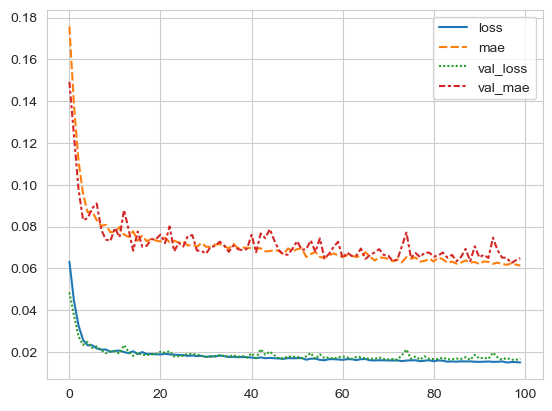

In [32]:
sns.lineplot(history_model_1.history)

While the decrease of loss levels out relatively quick after about 10 epochs, there is still a slight downward trend recognizable. Because the model complexity and the amount of data is rather low, epochs don't take very long to run. We will use an early stopping callback to let the training run for a high amount of epochs, until there is a divergence between training and validation loss, which would indicate overfitting.

In [33]:
# Early stopping callback that monitors validation loss and stops training after it stops decreasing for more than 25 epochs. Restores the model to the best weights it achieved on val loss afterwards.
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, restore_best_weights = True)

# Build a relatively simple neural net with a few layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_2 = model_2.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 10000,
                    callbacks = [early_stop])

Epoch 1/10000
244/244 [==============================] - 1s 1ms/step - loss: 0.0647 - mae: 0.1811 - val_loss: 0.0496 - val_mae: 0.1519
Epoch 2/10000
244/244 [==============================] - 0s 871us/step - loss: 0.0447 - mae: 0.1405 - val_loss: 0.0367 - val_mae: 0.1244
Epoch 3/10000
244/244 [==============================] - 0s 860us/step - loss: 0.0351 - mae: 0.1194 - val_loss: 0.0292 - val_mae: 0.1087
Epoch 4/10000
244/244 [==============================] - 0s 894us/step - loss: 0.0293 - mae: 0.1071 - val_loss: 0.0250 - val_mae: 0.0926
Epoch 5/10000
244/244 [==============================] - 0s 885us/step - loss: 0.0258 - mae: 0.0979 - val_loss: 0.0287 - val_mae: 0.1059
Epoch 6/10000
244/244 [==============================] - 0s 884us/step - loss: 0.0245 - mae: 0.0948 - val_loss: 0.0254 - val_mae: 0.1141
Epoch 7/10000
244/244 [==============================] - 0s 887us/step - loss: 0.0221 - mae: 0.0866 - val_loss: 0.0223 - val_mae: 0.0882
Epoch 8/10000
244/244 [====================

<Axes: >

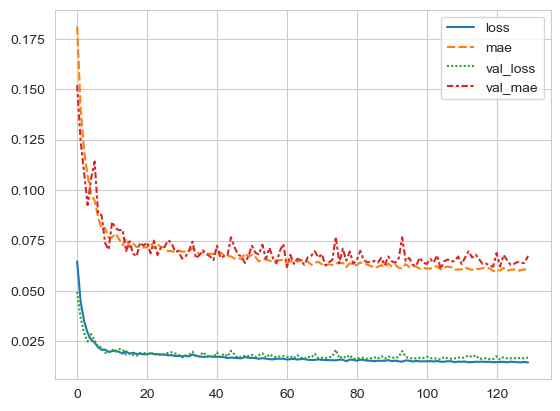

In [34]:
sns.lineplot(history_model_2.history)

Training stops after 130 epochs. With the early stopping, this means that validation loss stops decreasing after around 100 epochs. With there still being a downward trend in the training loss discernible at the end, this indicates that the model starts over-fitting to the training data at the end. One way to counter this in the model architecture is by using dropout layers in the first few layers. We'll add two drop-out layers in the beginning, with a drop-out ratio of 10% and increase the number epochs to 300.

In [47]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3 = model_3.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 1ms/step - loss: 0.0739 - mae: 0.1929 - val_loss: 0.0510 - val_mae: 0.1536
Epoch 2/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0489 - mae: 0.1438 - val_loss: 0.0386 - val_mae: 0.1255
Epoch 3/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0390 - mae: 0.1233 - val_loss: 0.0305 - val_mae: 0.1039
Epoch 4/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0313 - mae: 0.1069 - val_loss: 0.0242 - val_mae: 0.0873
Epoch 5/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0274 - mae: 0.0968 - val_loss: 0.0260 - val_mae: 0.0986
Epoch 6/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0260 - mae: 0.0927 - val_loss: 0.0210 - val_mae: 0.0750
Epoch 7/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0245 - mae: 0.0882 - val_loss: 0.0232 - val_mae: 0.0794
Epoch 8/300
244/244 [==============================] - 0s 1ms/step - 

<Axes: >

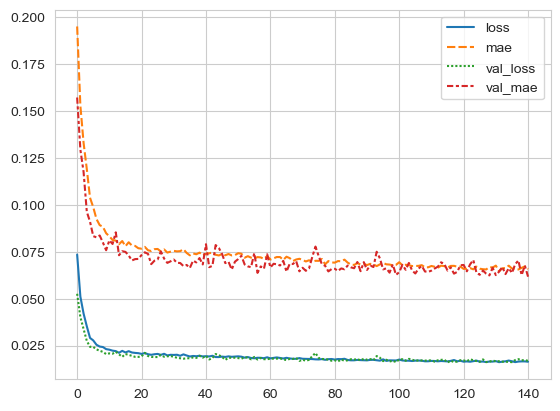

In [36]:
sns.lineplot(history_model_3.history)

Training stops after 150 epochs, with no remarkable difference in training or validation loss. This seems a good point to stop experimenting with this architecture. Now we'll test how well this architecture works with the data of site 2.

In [37]:
model_3_site_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3_site_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3_site_2 = model_3_site_2.fit(site_2_X_train,
                    site_2_y_train,
                    validation_data = (site_2_X_val,site_2_y_val),
                    epochs = 150)

Epoch 1/150
317/317 [==============================] - 1s 1ms/step - loss: 0.0265 - mae: 0.1193 - val_loss: 0.0178 - val_mae: 0.0935
Epoch 2/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0197 - mae: 0.0982 - val_loss: 0.0159 - val_mae: 0.0891
Epoch 3/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0185 - mae: 0.0945 - val_loss: 0.0157 - val_mae: 0.0894
Epoch 4/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0168 - mae: 0.0898 - val_loss: 0.0144 - val_mae: 0.0830
Epoch 5/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0161 - mae: 0.0879 - val_loss: 0.0141 - val_mae: 0.0812
Epoch 6/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0154 - mae: 0.0853 - val_loss: 0.0133 - val_mae: 0.0802
Epoch 7/150
317/317 [==============================] - 0s 1ms/step - loss: 0.0149 - mae: 0.0844 - val_loss: 0.0141 - val_mae: 0.0800
Epoch 8/150
317/317 [==============================] - 0s 1ms/step - 

<Axes: >

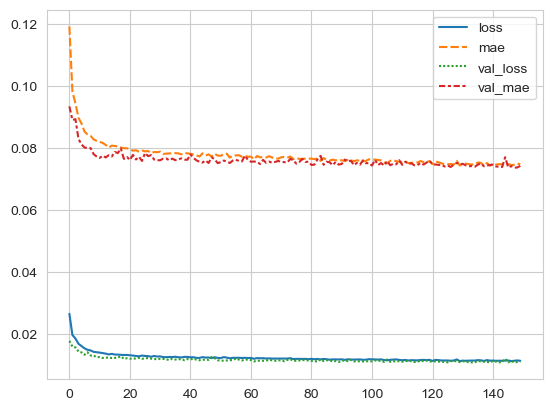

In [38]:
sns.lineplot(history_model_3_site_2.history)

While not big, training a model of the same architecture on site 2 training data, yields a small difference in final MAE. A possible for this explanation could be the difference between the two sites. Site 1, being the private charging site at a company, will probably have charging events that look more alike than site 2, the public charging site.
As a final step, let's try scaling up the model architecture, using more layers with a higher amount of neurons per layer.


In [39]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_4.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_4 = model_4.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0557 - mae: 0.1538 - val_loss: 0.0351 - val_mae: 0.1177
Epoch 2/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0357 - mae: 0.1114 - val_loss: 0.0241 - val_mae: 0.0884
Epoch 3/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0268 - mae: 0.0930 - val_loss: 0.0269 - val_mae: 0.0848
Epoch 4/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0257 - mae: 0.0886 - val_loss: 0.0234 - val_mae: 0.0832
Epoch 5/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0241 - mae: 0.0844 - val_loss: 0.0201 - val_mae: 0.0773
Epoch 6/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0270 - mae: 0.0912 - val_loss: 0.0218 - val_mae: 0.0867
Epoch 7/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0227 - mae: 0.0818 - val_loss: 0.0220 - val_mae: 0.0837
Epoch 8/300
244/244 [==============================] - 1s 3ms/step - 

<Axes: >

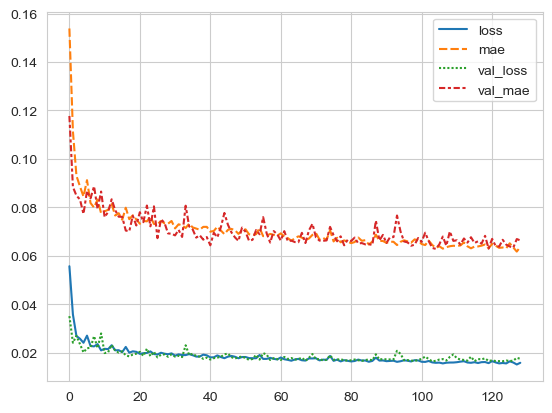

In [40]:
sns.lineplot(history_model_4.history)

The results of this are similar to the simpler architecture of model 3, with a higher complexity, resulting in longer training and inferencing times. While this is not really relevant to our current situation, this could lead to problems when trying to scale the system up.
Let's try the opposite, and use an even simpler model.

In [41]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_5.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_5 = model_5.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0630 - mae: 0.1670 - val_loss: 0.0385 - val_mae: 0.1225
Epoch 2/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0385 - mae: 0.1175 - val_loss: 0.0261 - val_mae: 0.0970
Epoch 3/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0279 - mae: 0.0950 - val_loss: 0.0209 - val_mae: 0.0731
Epoch 4/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0254 - mae: 0.0879 - val_loss: 0.0207 - val_mae: 0.0757
Epoch 5/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0234 - mae: 0.0839 - val_loss: 0.0204 - val_mae: 0.0750
Epoch 6/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0239 - mae: 0.0853 - val_loss: 0.0238 - val_mae: 0.0796
Epoch 7/300
244/244 [==============================] - 1s 2ms/step - loss: 0.0229 - mae: 0.0828 - val_loss: 0.0210 - val_mae: 0.0800
Epoch 8/300
244/244 [==============================] - 1s 2ms/step - 

<Axes: >

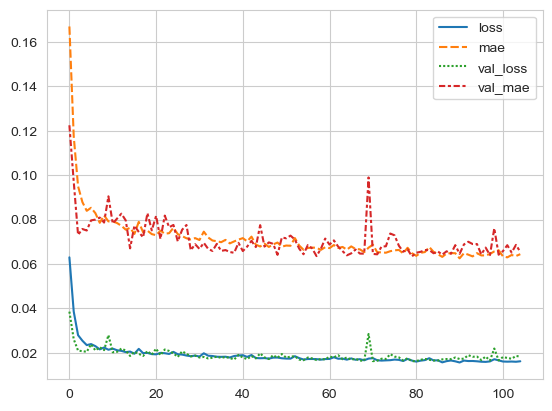

In [42]:
sns.lineplot(history_model_5.history)

The results of this are slightly worse than model 3, with over-fitting creeping in around epoch 90.
While further experimentation might yield slightly better results, they are not guaranteed. We will stop here and test the models, both site 1 and site 2, on the testing data to get our final result.

In [43]:
model_3.evaluate(site_1_X_test, site_1_y_test)

82/82 [==============================] - 0s 565us/step - loss: 0.0175 - mae: 0.0667


[0.01748347282409668, 0.06674033403396606]

In [44]:
model_3_site_2.evaluate(site_2_X_test, site_2_y_test)

106/106 [==============================] - 0s 536us/step - loss: 0.0117 - mae: 0.0763


[0.01171728502959013, 0.0763036459684372]